In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import torch
import copy
from torch.optim import Adam
import tools
import matplotlib.pyplot as plt
import numpy as np

In [46]:
import gymnasium as gym

In [1]:
# Prepare the environment
try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run

    assert (
        run(["pip", "install", "easypip"]).returncode == 0
    ), "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup(maze_mdp=True)

import os
import copy
import math
import bbrl_gymnasium  # noqa: F401
import torch
import torch.nn as nn
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl_utils.nn import build_mlp, setup_optimizer, soft_update_params
from bbrl_utils.notebook import setup_tensorboard
from omegaconf import OmegaConf

from bbrl_utils.algorithms import EpochBasedAlgo
from bbrl.visu.plot_policies import plot_policy

  Using cached easypip-1.3.5-py3-none-any.whl.metadata (475 bytes)
Using cached easypip-1.3.5-py3-none-any.whl (3.8 kB)


[easypip] Installing swig
[easypip] Installing bbrl_utils
/home/hocine/ENTER/envs/deepdac/lib/python3.9/site-packages/bbrl_utils/notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401


# TD3 implementation 

In [91]:
class TD3(EpochBasedAlgo):
    def __init__(self, cfg):
        # Appel du constructeur de la classe parente EpochBasedAlgo
        super().__init__(cfg)

        # Récupère la taille des observations et des actions depuis l'environnement d'entraînement
        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()

        # Initialisation du premier critique (critic_1) : réseau Q qui prend en entrée l'état et l'action
        # Il est utilisé pour estimer la valeur Q d'une action donnée dans un état donné.
        self.critic_1 = tools.ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic-1/")  # On donne un préfixe pour identifier ce réseau dans les logs
        
        # Initialisation du second critique (critic_2) : deuxième réseau Q
        # Le second critique est une copie du premier mais est utilisé pour atténuer les biais d'estimation.
        self.critic_2 = tools.ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic-2/")

        # Création des critiques cibles (target_critic_1 et target_critic_2) par copie des critiques originaux.
        # Les critiques cibles sont utilisés pour calculer les valeurs cibles de Q lors de l'apprentissage.
        self.target_critic_1 = copy.deepcopy(self.critic_1).with_prefix("target-critic-1/")
        self.target_critic_2 = copy.deepcopy(self.critic_2).with_prefix("target-critic-2/")

        # Initialisation de l'acteur : réseau déterministe qui prend en entrée l'état et produit l'action correspondante.
        self.actor = tools.ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )

        # Ajout de bruit gaussien à l'action pour favoriser l'exploration durant l'entraînement
        noise_agent = tools.AddGaussianNoise(cfg.algorithm.action_noise)

        # Définition de la politique d'entraînement : l'acteur avec du bruit pour l'exploration
        self.train_policy = Agents(self.actor, noise_agent)
        # Définition de la politique d'évaluation : acteur sans bruit (politique déterministe)
        self.eval_policy = self.actor

        # Création d'agents temporels pour traiter les informations au fil du temps.
        # Ils permettent d'appliquer les réseaux sur des séquences de données.
        self.t_actor = TemporalAgent(self.actor)
        self.t_critic_1 = TemporalAgent(self.critic_1)
        self.t_critic_2 = TemporalAgent(self.critic_2)
        self.t_target_critic_1 = TemporalAgent(self.target_critic_1)
        self.t_target_critic_2 = TemporalAgent(self.target_critic_2)

        # Configuration des optimizers pour l'acteur et les critiques
        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic_1, self.critic_2)

# Run

In [122]:
def run_td3(td3: TD3):
    # Listes pour enregistrer les données des courbes d'apprentissage
    critic_losses = []
    actor_losses = []
    rewards_per_episode = []

    # Boucle principale d'apprentissage TD3, qui itère sur le replay buffer (mémoire d'expériences)
    for rb in td3.iter_replay_buffers():
        # Extraction d'un batch d'expériences aléatoires depuis le replay buffer
        rb_workspace = rb.get_shuffled(td3.cfg.algorithm.batch_size)

        # Mise à jour des réseaux de critiques à t=0
        td3.t_critic_1(rb_workspace, t=0, n_steps=1)  # Calcul des valeurs Q pour critic_1
        td3.t_critic_2(rb_workspace, t=0, n_steps=1)  # Calcul des valeurs Q pour critic_2
        
        # Avec torch.no_grad() pour désactiver la backpropagation (pas de mise à jour ici)
        with torch.no_grad():
            # Application de l'acteur pour générer les actions futures à t=1
            td3.t_actor(rb_workspace, t=1, n_steps=1)
            # Calcul des valeurs Q cibles à t=1
            td3.t_target_critic_1(rb_workspace, t=1, n_steps=1)
            td3.t_target_critic_2(rb_workspace, t=1, n_steps=1)

        # Récupération des informations nécessaires du workspace pour les mises à jour
        q_values_1, q_values_2, terminated, reward, target_q_values_1, target_q_values_2 = rb_workspace[
            "critic-1/q_value", "critic-2/q_value", "env/terminated", "env/reward", "target-critic-1/q_value", "target-critic-2/q_value"
        ]
        # Calcul du masque pour identifier les transitions à bootstrapper (non terminées)
        must_bootstrap = ~terminated

        # Calcul des valeurs Q cibles : on prend le minimum des valeurs Q des deux critiques cibles (principe clé de TD3 pour éviter la surestimation des valeurs Q)
        target_q_values = torch.min(target_q_values_1, target_q_values_2)

        # --- Mise à jour des critiques ---
        # Calcul de la perte pour critic_1 en utilisant la fonction compute_critic_loss
        critic_loss_1 = tools.compute_critic_loss(
            td3.cfg, reward, must_bootstrap, q_values_1, target_q_values
        )
        # Calcul de la perte pour critic_2
        critic_loss_2 = tools.compute_critic_loss(
            td3.cfg, reward, must_bootstrap, q_values_2, target_q_values
        )
        # La perte totale des critiques est la somme des deux
        critic_loss = critic_loss_1 + critic_loss_2

        # Enregistrement de la perte des critiques dans les logs et listes
        td3.logger.add_log("critic_loss", critic_loss, td3.nb_steps)
        critic_losses.append(critic_loss.item())  # Sauvegarde des pertes

        # --- Mise à jour de l'acteur ---
        # Calcul des actions en utilisant l'acteur à t=0
        td3.t_actor(rb_workspace, t=0, n_steps=1)
        # Mise à jour du critic_1 avec ces actions
        td3.t_critic_1(rb_workspace, t=0, n_steps=1)

        # Récupération des valeurs Q issues de critic_1
        q_values = rb_workspace["critic-1/q_value"]
        # Calcul de la perte de l'acteur : l'objectif est de maximiser les valeurs Q sous la politique actuelle
        actor_loss = tools.compute_actor_loss(q_values)

        # Gradient step pour l'acteur
        td3.actor_optimizer.zero_grad()  # Réinitialisation des gradients
        actor_loss.backward()  # Calcul des gradients via backpropagation
        # Clipping de gradient pour l'acteur
        torch.nn.utils.clip_grad_norm_(
            td3.actor.parameters(), td3.cfg.algorithm.max_grad_norm
        )
        # Application de la mise à jour de l'acteur
        td3.actor_optimizer.step()

        # Sauvegarde de la perte de l'acteur
        actor_losses.append(actor_loss.item())

        # --- Mise à jour des cibles critiques avec soft update ---
        # Application de la mise à jour douce (soft update) des paramètres de critic_1 et target_critic_1
        soft_update_params(
            td3.critic_1, td3.target_critic_1, td3.cfg.algorithm.tau_target
        )
        # Application de la mise à jour douce pour critic_2 et target_critic_2
        soft_update_params(
            td3.critic_2, td3.target_critic_2, td3.cfg.algorithm.tau_target
        )
        
        # --- Enregistrement des récompenses cumulées ---
        rewards_per_episode.append(reward.sum().item())  # Ajout de la somme des récompenses de l'épisode

        # --- Évaluation de l'acteur si nécessaire ---
        if td3.evaluate():  # Si une évaluation est requise
            if td3.cfg.plot_agents:  # Si la configuration requiert de générer des plots
                # Génération des graphiques pour visualiser la politique de l'acteur
                plot_policy(
                    td3.actor,
                    td3.eval_env,
                    td3.best_reward,
                    str("." / "plots"),
                    td3.cfg.gym_env.env_name,
                    stochastic=False,  # Pas de stochasticité lors de l'évaluation
                )

    return critic_losses, actor_losses, rewards_per_episode 

### Hyperparameters

In [123]:
# Hyperparamètres principaux ajustés pour LunarLanderContinuous-v2
BATCH_SIZE = 128  # Augmenter la taille du batch pour plus de stabilité
TAU_TARGET = 0.005  # Mise à jour douce des cibles pour une meilleure stabilité
DISCOUNT_FACTOR = 0.99  # Horizon temporel plus long pour l'environnement LunarLander
LEARNING_RATE_ACTOR = 1e-3
LEARNING_RATE_CRITIC = 1e-3
ACTOR_HIDDEN_SIZE = [400, 300]  # Taille des couches cachées de l'acteur
CRITIC_HIDDEN_SIZE = [400, 300]  # Taille des couches cachées des critiques
ACTION_NOISE = 0.1  # Conserver le bruit d'action pour favoriser l'exploration
MAX_GRAD_NORM = 0.5
LEARNING_STARTS = 10000  # Commencer l'apprentissage après 10 000 pas
BUFFER_SIZE = int(1e6)  # Augmenter la taille du replay buffer à 1 million pour LunarLander
N_STEPS = 100  # Nombre de pas avant mise à jour
NB_EVALS = 10

# Créer l'environnement LunarLanderContinuous-v2
env = gym.make('LunarLanderContinuous-v2', render_mode='rgb_array')

# Initialisation des paramètres avec les hyperparamètres ajustés
params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/td3-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    "plot_agents": True,
    "algorithm": {
        "seed": 1,
        "max_grad_norm": MAX_GRAD_NORM,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": N_STEPS,
        "nb_evals": NB_EVALS,
        "discount_factor": DISCOUNT_FACTOR,  # Facteur d'actualisation ajusté
        "buffer_size": BUFFER_SIZE,  # Buffer augmenté
        "batch_size": BATCH_SIZE,  # Batch augmenté
        "tau_target": TAU_TARGET,  # Mise à jour douce ajustée
        "eval_interval": 2000,
        "max_epochs": 11000,
        "learning_starts": LEARNING_STARTS,
        "action_noise": ACTION_NOISE,
        "architecture": {
            "actor_hidden_size": ACTOR_HIDDEN_SIZE,
            "critic_hidden_size": CRITIC_HIDDEN_SIZE,
        },
    },
    "gym_env": {
        "env_name": "LunarLanderContinuous-v2",  #  LunarLanderContinuous-v2 - Pendulum-v1
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": LEARNING_RATE_ACTOR,  # Taux d'apprentissage pour l'acteur
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": LEARNING_RATE_CRITIC,  # Taux d'apprentissage pour les critiques
    },
}


### Run

In [141]:
td3 = TD3(OmegaConf.create(params))
critic_losses, actor_losses, rewards_per_episode= run_td3(td3)

# --- Affichage des courbes d'apprentissage à la fin de l'entraînement ---
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

# Courbe des pertes du critique
ax[0].plot(critic_losses)
ax[0].set_title("Critic Loss")
ax[0].set_xlabel("Training Steps")
ax[0].set_ylabel("Loss")

# Courbe des pertes de l'acteur
ax[1].plot(actor_losses)
ax[1].set_title("Actor Loss")
ax[1].set_xlabel("Training Steps")
ax[1].set_ylabel("Loss")

# Courbe des récompenses cumulées
ax[2].plot(rewards_per_episode)
ax[2].set_title("Cumulative Rewards per Episode")
ax[2].set_xlabel("Episode")
ax[2].set_ylabel("Total Reward")

plt.tight_layout()
plt.show()


  0%|          | 0/11000 [00:00<?, ?it/s]

TypeError: Converting from sequence to b2Vec2, expected int/float arguments index 0

In [ ]:
# td3 = TD3(OmegaConf.create(params))
# run_td3(td3)
# #td3.visualize_best()

  0%|          | 0/11000 [00:00<?, ?it/s]

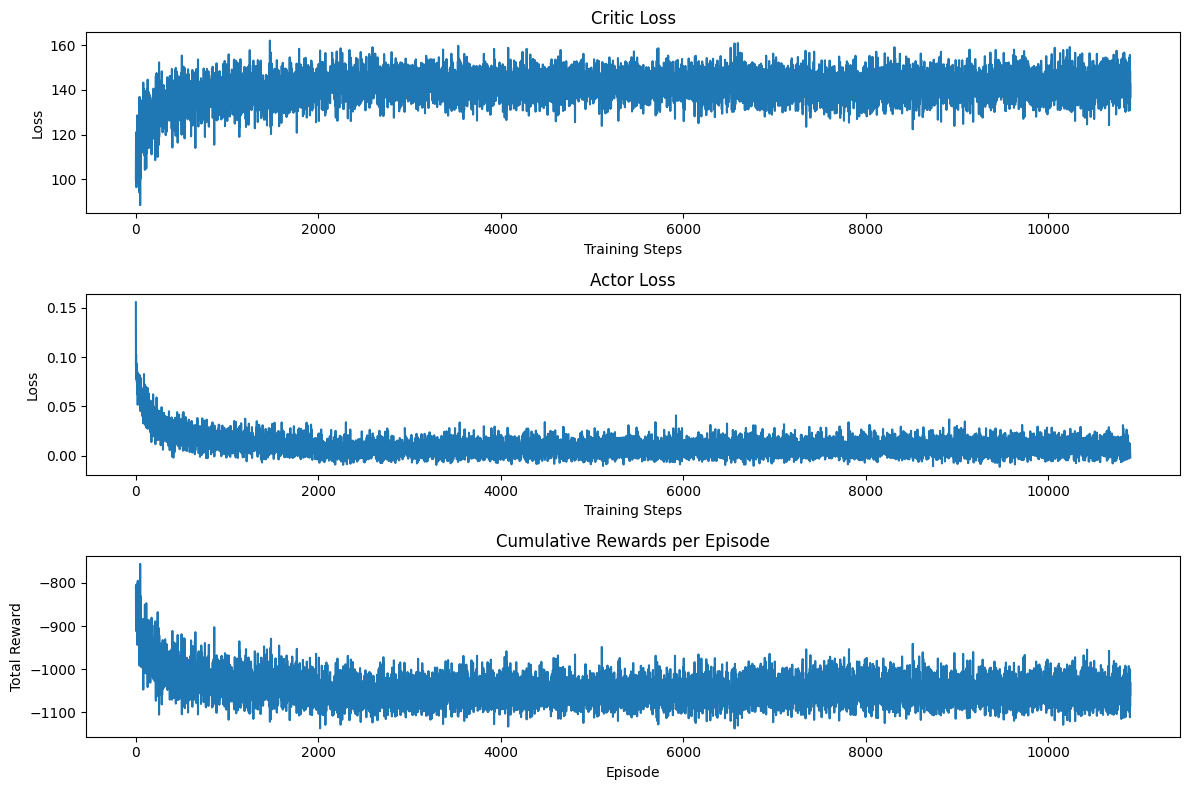

In [14]:
# td3 = TD3(OmegaConf.create(params))
# critic_losses, actor_losses, rewards_per_episode= run_td3(td3)

# # --- Affichage des courbes d'apprentissage à la fin de l'entraînement ---
# fig, ax = plt.subplots(3, 1, figsize=(12, 8))

# # Courbe des pertes du critique
# ax[0].plot(critic_losses)
# ax[0].set_title("Critic Loss")
# ax[0].set_xlabel("Training Steps")
# ax[0].set_ylabel("Loss")

# # Courbe des pertes de l'acteur
# ax[1].plot(actor_losses)
# ax[1].set_title("Actor Loss")
# ax[1].set_xlabel("Training Steps")
# ax[1].set_ylabel("Loss")

# # Courbe des récompenses cumulées
# ax[2].plot(rewards_per_episode)
# ax[2].set_title("Cumulative Rewards per Episode")
# ax[2].set_xlabel("Episode")
# ax[2].set_ylabel("Total Reward")

# plt.tight_layout()
# plt.show()